In [660]:
import math
from scipy.stats import norm

def BS_Delta(Parameters, Vola, Type, Strike):
    if  (Type == "Call"): w = 1
    elif(Type == "Put"): w = -1
    else: w = 1       
    fwd = Parameters["Forward"] * Parameters["SPOT"]
    Texp = Parameters["T_expiry"]
    d1 = (math.log(fwd/Strike) + 0.5*pow(Vola, 2) * Texp/365) / (Vola * pow(Texp/365, 0.5))
    d2 = d1 - pow(Vola*(Texp/365),0.5) #Delta
    # Spot Pips Delta
    if Parameters["Delta_type"]==1: delta = w * (1 - Parameters["IRate_CCY1"]/365 * Texp) * norm.cdf(w * d1)
    # Forward Pips Delta
    if Parameters["Delta_type"]==2: delta = w * norm.cdf(w * d1)
    # Spot Pips Premium Adjusted Delta
    if Parameters["Delta_type"]==3: delta = w * (1 - Parameters["IRate_CCY1"]/365*Texp) * (Strike/fwd) * norm.cdf(w * d2)
    # Forward Pips Premium Adjusted Delta
    if Parameters["Delta_type"]==4: delta = w * (Strike/fwd) * norm.cdf(w * d2)
    return float(delta)


In [594]:
import math
from scipy import optimize
from scipy.stats import invgauss

def Get_ATM_Strike(Parameters):
    def Fun(X_Strike,Parameters):
        return BS_Delta(Parameters, Parameters["Vola_ATM"], "Call", X_Strike) + BS_Delta(Parameters, Parameters["Vola_ATM"], "Put", X_Strike) 
    return optimize.fsolve(Fun, x0=Parameters["SPOT"], args=(Parameters),xtol=0.00000001)
    

def Delta_to_Strike(Parameters, Vola, Type, Delta):
    if  (Type == "Call"): w = 1
    elif(Type == "Put"): w = -1
    else: w = 1
    fwd = Parameters["Forward"] * Parameters["SPOT"]
    Texp = Parameters["T_expiry"]
    K1 = fwd*math.exp(-w*Vola*pow(Texp/365,0.5)*norm.ppf(Delta)+0.5*Texp/365*pow(Vola,2))
    ERROR = 1
    for i in range (0, 20):
        if abs(ERROR)<=0.0000001: break
        else:
            TGA = (BS_Delta(Parameters, Vola, Type, K1+0.0001)-BS_Delta(Parameters, Vola, Type, K1-0.0001))/0.0002
            K1=(K1-(BS_Delta(Parameters, Vola, Type, K1)-w*Delta)/TGA)
        ERROR = w*Delta + w * BS_Delta(Parameters, Vola, Type, K1)
    x_strike = K1
    return x_strike

In [847]:
import matplotlib.pyplot as plt
def Plot_all(MainDataSet):
    fig, axs = plt.subplots(5,figsize=(5,15))
    for i in range(0,MainDataSet.shape[0]):
        fwd = MainDataSet.iloc[i]["Forward"]*MainDataSet.iloc[i]["SPOT"]
        T=MainDataSet.iloc[i]["T_expiry"]/365
        Alpha=MainDataSet.iloc[i]["Alpha"]
        Rho=MainDataSet.iloc[i]["Rho"]
        Nu=MainDataSet.iloc[i]["Nu"]
        Beta2=MainDataSet.iloc[i]["Beta"]
        Strike_true = [MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i]["Strike_Put_25"], 
                      MainDataSet.iloc[i]["Strike_ATM"],
                      MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i]["Strike_Call_10"]]
        Vola_true = [MainDataSet.iloc[i]["Vola_Put_10"],MainDataSet.iloc[i]["Vola_Put_25"], 
                      MainDataSet.iloc[i]["Vola_ATM"],
                      MainDataSet.iloc[i]["Vola_Call_25"],MainDataSet.iloc[i]["Vola_Call_10"]]
        Vola_SABR = [SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_10"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_25"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_ATM"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_25"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_10"])
                    ]
        Vola_BID =   [SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_10"])-VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_25"])-VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_25"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_ATM"])-VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_ATM"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_25"])-VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_10"])-VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_10"],MainDataSet.iloc[i])/2
                     ]
        Vola_ASK =   [SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_10"])+VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_25"])+VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_25"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_ATM"])+VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_ATM"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_25"])+VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i])/2,
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_10"])+VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_10"],MainDataSet.iloc[i])/2
                     ] 
        Vola_BID_A = [Vola_BID[0]-ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i]),
                     Vola_BID[1]-ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_25"],MainDataSet.iloc[i]),
                     Vola_BID[2]-ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_ATM"],MainDataSet.iloc[i]),
                     Vola_BID[3]-ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i]),
                     Vola_BID[4]-ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_10"],MainDataSet.iloc[i])
                     ]
        Vola_ASK_A = [Vola_ASK[0]+ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i]),
                     Vola_ASK[1]+ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Put_25"],MainDataSet.iloc[i]),
                     Vola_ASK[2]+ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_ATM"],MainDataSet.iloc[i]),
                     Vola_ASK[3]+ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i]),
                     Vola_ASK[4]+ADDITIONAL_VOLA_BidAsk_Spread(MainDataSet.iloc[i]["Strike_Call_10"],MainDataSet.iloc[i])
                     ]
        
        axs[i].plot(Strike_true,Vola_true,"ro",Strike_true,Vola_SABR,"-")
        axs[i].plot(Strike_true,Vola_true,"-")
        axs[i].plot(Strike_true,Vola_BID,linestyle = "dotted")
        axs[i].plot(Strike_true,Vola_ASK,linestyle = "dotted")
        axs[i].plot(Strike_true,Vola_BID_A,linestyle ='-')
        axs[i].plot(Strike_true,Vola_ASK_A,linestyle ='-')
        axs[i].title.set_text(MainDataSet.iloc[i]["Error_Value"])
        Strike_true=[]
        Vola_true=[]
        Vola_BID=[]
        Vola_ASK=[]
        Vola_BID_A = []
        Vola_ASK_A = []
    return "Done"

In [899]:
import numpy as np

def SABR_2002(FWD,tau,a0,rho,nu,bet,OptionalStrike):
    try:
        K = OptionalStrike
        h = 1-bet
        p = pow((FWD * K),(h / 2))
        q = math.log(FWD/K)
        v = pow(h, 2) * pow(a0,2) / (24 * pow(p, 2)) + rho * bet * nu * a0 / (4 * p) + (2 - 3 * pow(rho, 2)) * pow(nu,2) / 24
        eps = 0.00000001
        if abs(q) < eps:
            eta = p
            zeta_chi = 1 
        elif abs(h) < eps:
            eta = 1
            zeta = nu / a0 * q
            zeta_chi = zeta / math.log((pow(1 - 2 * rho * zeta + pow(zeta,2),0.5) + zeta - rho)/ (1 - rho)) 
        else: 
            eta = (pow(FWD, h) - pow(K, h)) / (h * q)
            zeta = nu / a0 * p * q
            zeta_chi = zeta / math.log((sqrt(1 - 2 * rho * zeta + pow(zeta, 2)) + zeta - rho)/ (1 - rho))
    except:
        return 999999999
    return zeta_chi * (a0 * (1 + v * tau)) / eta


def BS_FX_Price(fwd,Texp,IRate_CCY2, Vola, Strike, Type):
    try:
        if  (Type == "Call"): w = 1
        elif(Type == "Put"): w = -1
        else: w = 1        
        d1 = (math.log(fwd/Strike) + 0.5*pow(Vola, 2) * Texp/365) / (Vola * pow(Texp/365, 0.5))
        d2 = d1 - pow(Vola*(Texp/365),0.5) #BS price
        #print(["New dd",d1,d2])
        return w * (1-Texp*IRate_CCY2/365)*(fwd * norm.cdf(w * d1) - Strike*norm.cdf(w * d2))/fwd
    except:
        print(Vola)
        
_DEBUG = False
def _debug(debug_input):
    if (__name__ == "__main__") and (_DEBUG == True):
        print(debug_input)
        
def _gbs(option_type, fs, x, t, r, b, v):
    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        # it's a call
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
        delta = math.exp((b - r) * t) * norm.cdf(d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(d1) - r * x * math.exp(-r * t) * norm.cdf(d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = x * t * math.exp(-r * t) * norm.cdf(d2)
    else:
        # it's a put
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        delta = -math.exp((b - r) * t) * norm.cdf(-d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) + (b - r) * fs * math.exp(
            (b - r) * t) * norm.cdf(-d1) + r * x * math.exp(-r * t) * norm.cdf(-d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = -x * t * math.exp(-r * t) * norm.cdf(-d2)
    
    return value, delta, gamma, theta, vega, rho    
        

def SABR_Parametric_Fit(X_rn, Parameters): #X = [Nu, Rho, Alpha]
    Beta2 = Parameters["Beta"]
    T = Parameters["T_expiry"] / 365
    fwd = Parameters["Forward"] * Parameters["SPOT"]
    Rho = X_rn[1]
    Nu = X_rn[0]
    Alpha =  X_rn[2]
    k = 100
    ErrorSum = 0
    # ATM
    ErrorSum = ErrorSum + pow(k * abs(Parameters["Vola_ATM"]-SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,Parameters["Strike_ATM"]))/abs(Parameters["Vola_ATM"]),2)
    for TargetDelta in [25, 10]:
        ErrorSum = ErrorSum + pow(k * abs(Parameters["Vola_RR_"+str(TargetDelta)] - 
        (SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,Parameters["Strike_Call_"+str(TargetDelta)]) - 
        SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,Parameters["Strike_Put_"+str(TargetDelta)]))) / abs(Parameters["Vola_RR_"+str(TargetDelta)]),2)
        
        Smile = (BS_FX_Price(fwd,Parameters["T_expiry"],Parameters["IRate_CCY2"],Parameters["Vola_Call_"+str(TargetDelta)],
                Parameters["Strike_Call_"+str(TargetDelta)],"Call") + 
                BS_FX_Price(fwd,Parameters["T_expiry"],Parameters["IRate_CCY2"],Parameters["Vola_Put_"+str(TargetDelta)],
                Parameters["Strike_Put_"+str(TargetDelta)],"Put"))
        
        ErrorSum = ErrorSum + pow(k * abs(
                   (BS_FX_Price(fwd,Parameters["T_expiry"],Parameters["IRate_CCY2"],
                   SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,Parameters["Strike_Call_"+str(TargetDelta)]),
                   Parameters["Strike_Call_"+str(TargetDelta)],"Call") + 
                   BS_FX_Price(fwd,Parameters["T_expiry"],Parameters["IRate_CCY2"],
                   SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,Parameters["Strike_Put_"+str(TargetDelta)]),
                   Parameters["Strike_Put_"+str(TargetDelta)],"Put") - Smile) / Smile),2)
        
    return ErrorSum

def SABR_Calibration(Parameters):
    def callbackF(Xi,convergence):
        print ([Xi[0], Xi[1], Xi[2]]) 
    B = [(0.001,5),(-0.999,0.999),(0.001,5)]
    #Xinit = [Parameters["Nu"],Parameters["Rho"],Parameters["Alpha"]]
    Xinit = []
    for i in range(1,36):
        Xinit.append([0.1*i,Parameters["Rho"],Parameters["Alpha"],999])
    
    Xx = pd.DataFrame(Xinit, columns = ["Nu","Rho","Alpha","Error"])
    Xx["Error"] = Xx.apply(lambda row: SABR_Parametric_Fit([row["Nu"],row["Rho"],row["Alpha"]],Parameters), axis = 1)

    #Xinit = [Parameters["Nu"],Parameters["Rho"],Parameters["Alpha"]]
    #res = optimize.differential_evolution(SABR_Parametric_Fit, bounds = B, args=(Parameters,), 
    #                strategy='rand2bin', maxiter=100, popsize=5, tol=0.01, recombination=0.7) #,callback=callbackF
    #res = optimize.basinhopping(SABR_Parametric_Fit, x0=Xinit, minimizer_kwargs={"args": (Parameters,)},
    #                           niter=70, interval=15)
    #Xinit = [res.x[0],res.x[1],res.x[2]]
    X0 = Xx[Xx["Error"]==Xx["Error"].min()].values.tolist()[0][0:3]
    Xinit = X0 #[X0["Nu"],X0["Rho"],X0["Alpha"]]
    res = optimize.minimize(SABR_Parametric_Fit,x0=Xinit,method="Powell",bounds = B, args=(Parameters,))
    Nu = res.x[0]
    Rho = res.x[1]
    Alpha =  res.x[2] 
    #print([Alpha,Nu,Rho,res.fun])
    return [Alpha,Nu,Rho,res.fun]

from scipy import interpolate

def VOLA_BidAsk_Spread(K, Parameters):
    Vola_SPREAD = [Parameters["Vola_10_Spread"], Parameters["Vola_25_Spread"],
                   Parameters["Vola_ATM_Spread"],
                   Parameters["Vola_25_Spread"], Parameters["Vola_10_Spread"]]
    Strike = [Parameters["Strike_Put_10"], Parameters["Strike_Put_25"], 
                   Parameters["Strike_ATM"],
                   Parameters["Strike_Call_25"], Parameters["Strike_Call_10"]]
    f = interpolate.interp1d(Strike, Vola_SPREAD, kind='linear')
    return f(K)

def ADDITIONAL_VOLA_BidAsk_Spread(K, Parameters):
    Vola_SPREAD = Check_Errors(MainDataSet)
    Strike = [Parameters["Strike_Put_10"], Parameters["Strike_Put_25"], 
                   Parameters["Strike_ATM"],
                   Parameters["Strike_Call_25"], Parameters["Strike_Call_10"]]
    f = interpolate.interp1d(Strike, Vola_SPREAD, kind='linear')
    return f(K)


In [809]:
def Check_Errors(MainDataSet):
    difference = []
    for i in range(0,MainDataSet.shape[0]):
        fwd = MainDataSet.iloc[i]["Forward"]*MainDataSet.iloc[i]["SPOT"]
        T=MainDataSet.iloc[i]["T_expiry"]/365
        Alpha=MainDataSet.iloc[i]["Alpha"]
        Rho=MainDataSet.iloc[i]["Rho"]
        Nu=MainDataSet.iloc[i]["Nu"]
        Beta2=MainDataSet.iloc[i]["Beta"]
        Strike_true = [MainDataSet.iloc[i]["Strike_Put_10"],MainDataSet.iloc[i]["Strike_Put_25"], 
                      MainDataSet.iloc[i]["Strike_ATM"],
                      MainDataSet.iloc[i]["Strike_Call_25"],MainDataSet.iloc[i]["Strike_Call_10"]]
        Vola_true = [MainDataSet.iloc[i]["Vola_Put_10"],MainDataSet.iloc[i]["Vola_Put_25"], 
                      MainDataSet.iloc[i]["Vola_ATM"],
                      MainDataSet.iloc[i]["Vola_Call_25"],MainDataSet.iloc[i]["Vola_Call_10"]]
        Vola_SABR = [SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_10"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Put_25"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_ATM"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_25"]),
                     SABR_2002(fwd,T,Alpha,Rho,Nu,Beta2,MainDataSet.iloc[i]["Strike_Call_10"])
                    ]
        dif = []
        zip_object = zip(Vola_SABR, Vola_true)
        for Vola_SABR_i, Vola_true_i in zip_object:
            dif.append(abs(round((Vola_SABR_i-Vola_true_i),5)))
        difference.append(max(dif))
    return difference

def Check_BF(MainDataSet,Delta):
    Real = BS_FX_Price(MainDataSet["Forward"]*MainDataSet["SPOT"],
                MainDataSet["T_expiry"],MainDataSet["IRate_CCY2"],
                MainDataSet["Vola_Call_"+str(Delta)],MainDataSet["Strike_Call_"+str(Delta)],"Call") + \
    BS_FX_Price(MainDataSet["Forward"]*MainDataSet["SPOT"],
                MainDataSet["T_expiry"],MainDataSet["IRate_CCY2"],
                MainDataSet["Vola_Put_"+str(Delta)],MainDataSet["Strike_Put_"+str(Delta)],"Put")

    Synth = BS_FX_Price(MainDataSet["Forward"]*MainDataSet["SPOT"],
                MainDataSet["T_expiry"],MainDataSet["IRate_CCY2"],
                SABR_2002(MainDataSet["Forward"]*MainDataSet["SPOT"],
                          MainDataSet["T_expiry"]/365,
                          MainDataSet["Alpha"],
                          MainDataSet["Rho"],
                          MainDataSet["Nu"],
                          MainDataSet["Beta"],
                          MainDataSet["Strike_Call_"+str(Delta)]),
                          MainDataSet["Strike_Call_"+str(Delta)], "Call") + \
            BS_FX_Price(MainDataSet["Forward"]*MainDataSet["SPOT"],
                MainDataSet["T_expiry"],MainDataSet["IRate_CCY2"],
                SABR_2002(MainDataSet["Forward"]*MainDataSet["SPOT"],
                          MainDataSet["T_expiry"]/365,
                          MainDataSet["Alpha"],
                          MainDataSet["Rho"],
                          MainDataSet["Nu"],
                          MainDataSet["Beta"],
                          MainDataSet["Strike_Put_"+str(Delta)]),
                          MainDataSet["Strike_Put_"+str(Delta)], "Put")
    return round(Real-Synth,4)

In [895]:
import pandas as pd
from scipy import interpolate

def Create_Matrix(DD,SPOT):
    MarketData = pd.DataFrame(DD) #pd.read_csv('C:/Users/Макс/Documents/MATLAB/DataVS.csv',sep = ";", header=None)
    MarketData.columns = ["Days","SWAP_Points","CCY1_Rates", "Delta_Conv",   
       "ATM_Conv","ATM_MID", "ATM_S","25RR_MID","25RR_S","25BF_MID", 
       "25BF_S","10RR_MID","10RR_S","10BF_MID","10BF_S"]
    Col = ["T_expiry","T_delivery","SPOT","Forward","Delta_type","IRate_CCY1",
        "IRate_CCY2","Vola_RR_25","Vola_BF_25","Vola_RR_10","Vola_BF_10",
        "Vola_ATM_Spread","Vola_25_Spread","Vola_10_Spread",
        "Vola_Put_10","Vola_Put_25","Vola_ATM","Vola_Call_25",
        "Vola_Call_10","Strike_Put_10","Strike_Put_25","Strike_ATM",
        "Strike_Call_25","Strike_Call_10","Alpha","Nu","Rho","Beta",
        "Error_Value","25BF_Check","10BF_Check"]
    Rws = list(MarketData["Days"].T)
    MainDataSet = pd.DataFrame(index = Rws, columns = Col)

    MainDataSet["T_expiry"] = list(MarketData["Days"])
    MainDataSet["T_delivery"] = list(MarketData["Days"])
    MainDataSet["SPOT"] = SPOT

    f_fwd = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["SWAP_Points"]))
    f_DeltaType = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["Delta_Conv"]))
    f_IR1 = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["CCY1_Rates"]))
    f_25RR_M = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["25RR_MID"]))
    f_25RR_S = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["25RR_S"]))
    f_25BF_M = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["25BF_MID"]))
    f_25BF_S = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["25BF_S"]))
    f_10RR_M = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["10RR_MID"]))
    f_10RR_S = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["10RR_S"]))
    f_10BF_M = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["10BF_MID"]))
    f_10BF_S = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["10BF_S"]))
    f_ATM_M = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["ATM_MID"]))
    f_ATM_S = interpolate.interp1d(list(MarketData["Days"]), list(MarketData["ATM_S"]))

    MainDataSet["Forward"] = MainDataSet.apply(lambda row: (row["SPOT"]+f_fwd(row["T_delivery"])/10000)/row["SPOT"], axis = 1)
    MainDataSet["Delta_type"] = MainDataSet.apply(lambda row: f_DeltaType(row["T_delivery"]), axis = 1)
    MainDataSet["IRate_CCY1"] = MainDataSet.apply(lambda row: f_IR1(row["T_delivery"]), axis = 1)
    MainDataSet["IRate_CCY2"] = MainDataSet.apply(lambda row: 
                                (f_fwd(row["T_delivery"])/10000 + row["IRate_CCY1"]* row["Forward"])/
                                row["SPOT"] * 365 / row["T_delivery"]/365 * row["T_delivery"], axis = 1)  

    MainDataSet["Vola_RR_25"] = MainDataSet.apply(lambda row: f_25RR_M(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_BF_25"] = MainDataSet.apply(lambda row: f_25BF_M(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_RR_10"] = MainDataSet.apply(lambda row: f_10RR_M(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_BF_10"] = MainDataSet.apply(lambda row: f_10BF_M(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_ATM"] = MainDataSet.apply(lambda row: f_ATM_M(row["T_expiry"]), axis = 1)

    MainDataSet["Vola_Call_25"] = MainDataSet.apply(lambda row:(row["Vola_ATM"]+row["Vola_BF_25"]+0.5*row["Vola_RR_25"]), axis = 1)
    MainDataSet["Vola_Put_25"] = MainDataSet.apply(lambda row:(row["Vola_ATM"]+row["Vola_BF_25"]-0.5*row["Vola_RR_25"]), axis = 1)
    MainDataSet["Vola_Call_10"] = MainDataSet.apply(lambda row:(row["Vola_ATM"]+row["Vola_BF_10"]+0.5*row["Vola_RR_10"]), axis = 1)
    MainDataSet["Vola_Put_10"] = MainDataSet.apply(lambda row:(row["Vola_ATM"]+row["Vola_BF_10"]-0.5*row["Vola_RR_10"]), axis = 1)

    MainDataSet["Vola_ATM_Spread"] = MainDataSet.apply(lambda row: f_ATM_S(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_25_Spread"] = MainDataSet.apply(lambda row: f_25RR_S(row["T_expiry"]), axis = 1)
    MainDataSet["Vola_10_Spread"] = MainDataSet.apply(lambda row: f_10RR_S(row["T_expiry"]), axis = 1)

    MainDataSet["Strike_ATM"] = MainDataSet.apply(lambda row: float(Get_ATM_Strike(MainDataSet.loc[row.name])), axis = 1)
    MainDataSet["Strike_Put_10"] = MainDataSet.apply(lambda row: Delta_to_Strike(MainDataSet.loc[row.name], MainDataSet.loc[row.name]["Vola_Put_10"], "Put", 0.10), axis = 1)
    MainDataSet["Strike_Put_25"] = MainDataSet.apply(lambda row: Delta_to_Strike(MainDataSet.loc[row.name], MainDataSet.loc[row.name]["Vola_Put_25"], "Put", 0.25), axis = 1)
    MainDataSet["Strike_Call_10"] = MainDataSet.apply(lambda row: Delta_to_Strike(MainDataSet.loc[row.name], MainDataSet.loc[row.name]["Vola_Call_10"], "Call", 0.10), axis = 1)
    MainDataSet["Strike_Call_25"] = MainDataSet.apply(lambda row: Delta_to_Strike(MainDataSet.loc[row.name], MainDataSet.loc[row.name]["Vola_Call_25"], "Call", 0.25), axis = 1)

    MainDataSet["Alpha"] = MainDataSet.apply(lambda row: row["Vola_ATM"], axis = 1)
    MainDataSet["Nu"] = MainDataSet.apply(lambda row: 0.5, axis = 1)
    MainDataSet["Rho"] = MainDataSet.apply(lambda row: 0.5*np.sign(row["Vola_RR_25"]+row["Vola_RR_10"]), axis = 1)
    MainDataSet["Beta"] = MainDataSet.apply(lambda row: 1, axis = 1)

    for row in MainDataSet.index:
        res = SABR_Calibration(MainDataSet.loc[row])
        MainDataSet.at[row,"Alpha"] = res[0]
        MainDataSet.at[row,"Nu"] = res[1]
        MainDataSet.at[row,"Rho"] = res[2]
        MainDataSet.at[row,"Error_Value"] = res[3]
    
    MainDataSet["25BF_Check"] = MainDataSet.apply(lambda row: Check_BF(MainDataSet.loc[row.name],25), axis = 1)
    MainDataSet["10BF_Check"] = MainDataSet.apply(lambda row: Check_BF(MainDataSet.loc[row.name],10), axis = 1)
    
    return MainDataSet


'Done'

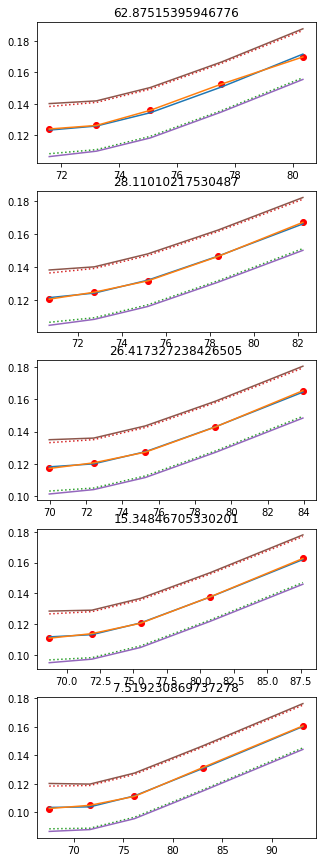

In [912]:
DD=[[35,  3746.5,  0.0023,  4, 3, 0.136,   0.03, 0.02625, 0.03, 0.0035,  0.03, 0.04575, 0.03, 0.011,   0.03],
    [63,  6835,    0.003,   4, 3, 0.1315,  0.03, 0.02175, 0.03, 0.004,   0.03, 0.04675, 0.03, 0.01225, 0.03],
    [96,  10081.5, 0.0041,  4, 3, 0.12725, 0.03, 0.02225, 0.03, 0.0045,  0.03, 0.04825, 0.03, 0.014,   0.03],
    [188, 18860.5, 0.0061,  4, 3, 0.1205,  0.03, 0.024,   0.03, 0.00525, 0.03, 0.052,   0.03, 0.01625, 0.03],
    [369, 35330,   0.00681, 4, 3, 0.11125, 0.03, 0.0265,  0.03, 0.007,   0.03, 0.058,   0.03, 0.0205,  0.03]
   ]
SPOT = 75
MainDataSet = Create_Matrix(DD,SPOT)
Plot_all(MainDataSet)

In [911]:
i=0
#print(MainDataSet)
fwd = MainDataSet.iloc[i]["Forward"]*MainDataSet.iloc[i]["SPOT"]
Texp = MainDataSet.iloc[i]["T_expiry"]
IRate_CCY2 = MainDataSet.iloc[i]["IRate_CCY2"]
Vola = MainDataSet.iloc[i]["Vola_Call_25"]
Strike = MainDataSet.iloc[i]["Strike_Call_25"]
print([fwd,Texp,IRate_CCY2, Vola, Strike, "Call"])
print(100*BS_FX_Price(fwd,Texp,IRate_CCY2, Vola, Strike, "Call"))

# Inputs: option_type = "p" or "c", fs = price of underlying, x = strike, t = time to expiration, 
# r = risk free rate
# b = cost of carry, v = implied volatility
r =  MainDataSet.iloc[i]["IRate_CCY2"]
b =  MainDataSet.iloc[i]["IRate_CCY2"] - MainDataSet.iloc[i]["IRate_CCY1"]
print(100*_gbs("c", 
               MainDataSet.iloc[i]["SPOT"], 
               MainDataSet.iloc[i]["Strike_Call_25"], 
               MainDataSet.iloc[i]["T_expiry"]/365,
               r, b, Vola)[0]/MainDataSet.iloc[i]["Strike_Call_25"])

print(100*BS_FX_Price(77.193,365,0.0643, 0.19001, 90, "Call"))
print(100*_gbs("c", 
               73.5275, 
               90, 
               1,
               0.0643, 0.0643-0.007, 0.19001)[0]/MainDataSet.iloc[i]["Strike_Call_25"])

2.55

[75.37465, 35, 0.005026153190222222, 0.152625, 77.54002711086224, 'Call']
3.241045899332274
0.6647097696406212
8.594092867841164
2.4633494645697946


2.55

In [841]:
def Request_Pricing_Vanilla(Symbol,Data_date, Type, Style, Barrier, Direction, T_expiry, SPOT, Strike):
    return Result

def Request_Pricing_Collar(Symbol, T_expiry, Type, Direction, SPOT, Strike, Optimize_Target):
    return Result

from pandas import *
def Surface_create(Path_name):
    xls = pd.read_excel(Path_name, sheet_name="Vola_surface")
    result={}
    for symbole in xls["Symbol"].unique():
        tempDF = xls[xls["Symbol"]==symbole]
        temp = {
                "Date": tempDF.iloc[0]["Date"],
                "Symbol": symbole,
                "SPOT": tempDF.iloc[0]["SPOT"],
                "Data": Create_Matrix(tempDF.drop(["Date","SPOT","Symbol"],axis=1).values.tolist(),tempDF.iloc[0]["SPOT"])
                }
        result[symbole]=temp.copy()
        tempDF=[]
        temp.clear()
    return result

0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108
0.00183
0.00097
0.001
0.00086
0.00108


'Done'

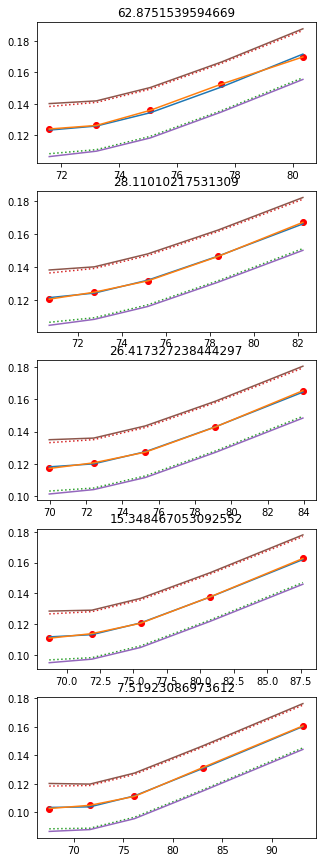

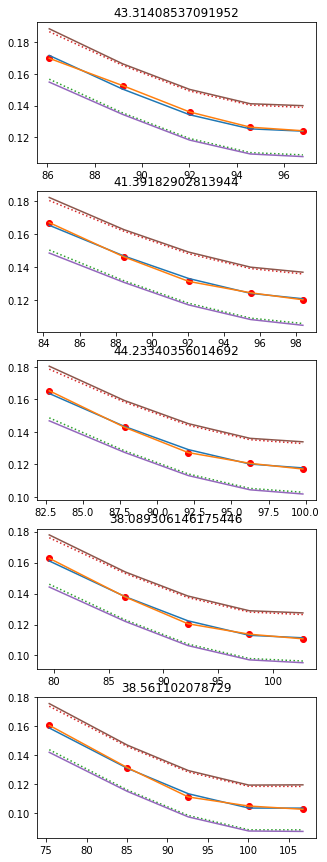

In [849]:
#MainDataSet[["T_expiry","T_delivery","SPOT","Forward","Delta_type","IRate_CCY1","IRate_CCY2",
#             "Vola_ATM_Spread","Vola_25_Spread","Vola_10_Spread","Alpha","Nu","Rho","Beta"]].T


#print(Check_Errors(MainDataSet))
#Plot_all(MainDataSet)

ff = Surface_create("/Users/a1/Documents/Template.xlsx")
Plot_all(ff["USD/RUB"]["Data"])
Plot_all(ff["EUR/RUB"]["Data"])
    

In [850]:
    Xinit = [
             [0.1,0.5,1],
             [0.4,0.5,1],
             [0.9,0.5,1]             
            ]
    len(Xinit)

3